 # Куприянов Артем
 # Группа: 599а

# 0) При реализации алгоритма разрешается использовать только библиотеки из requierments.txt

В него входит:
1. jupyter - библиотека для показа ноутбуков
2. numpy - библиотека для вычислений
3. matplotlib - библиотека для визуализации

## Установка 

1. Устанавливаем python3 и virtualenv
2. создаем окружение virtualenv --no-site-packages  lin_prog
3. активируем окружение source activate lin_prog
4. устанавливаем зависимости pip install -r requirements.txt
5. запускаем jupyter и начинаем работать jupyter notebook



In [2]:
from math import sin
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# ============================================================
# Задача на Симплекс метод

## 1) На вход Вашему функцию должны приходить:

0. число переменных = n
1. матрица A (n x m) (tsv, вещественные числа)
2. вектор  b  ограничений типа неравнство
4. вектор c функции полезности для задачи max cx 
5. алгоритм выбора входящей переменной (правило Бленда, Лексикографический метод)
6. (не обязательный параметр) стартовую базисную точку

## 2) На выход программа должна выдавать:

### Обязательная часть (0.3 баллов):
0. Ответ и оптимальную точку при положительных компонентах вектора b
1. Количество итераций потребовавшихся для решения задачи
2. при n=2 выдавать процесс решения (draw=True)
3. Напишите программу которая будет отвечать на вопрос оптимально ли приведенное решение, например


### Дополнительная часть  (0.8 балл):
0. Максимально использовать матричные вычисления (0.2 балла)
1. Работать в случае отрицательных чисел в векторе b (0.2 балла)




### Вначале напишем задачу на симплекс метод, т.к. позже она пригодится при решении задачи МНК

Реализуем класс, который будет решать задачу лин программирования симплекс методом. Вход класса описан выше. 

### Немного теории,  которая была мною использована:

** Метод Бланда **

Входящая переменная:
Имеющая минимальный индекс среди тех, чей коэффициент целевой фунцкии > 0

Выходящая переменная:
Та, для для которой достигается максимум $\dfrac{a_{im}}{b_i}$

** Лексикографический метод **

Входящая переменная:
Выбираем случайно

Выходящая переменная:
Каждую строчку матрицы $A$ поделим на соответствующий элемент матрицы $b$ и возьмем строчку, которая будет наименьшей в лексикографическом смысле


Далее использован алгоритм из pdf-ки, которую скинул Тренин про лексикографический метод


### Проверка на оптимальность

Решаем двойственную задачу симплекс метода, которая имеет вид: 

$$b^Ty \to \min$$
$$A^Ty \geq c$$
$$y \geq 0$$

И говорим, что по теореме о сильной двойственности:

Если $x_{opt}$ -- допустимое решение прямой задачи, а $y_{opt}$ -- допустимое решение решение двойственной задача симплекс метода ивыполнена формула:
$$\sum_i c_ix_{opt, i} = \sum_i b_iy_{opt, i}$$

То, $x_{opt}$ и $y_{opt}$ -- оптимальные решения

Ну вот и будем проверять это условие. Если оно выполнилось, то наше решение является оптимальным.

Когда некоторые значения коэффициентов b отрицательные, то стартовая точка $(0, \dots, 0)$ становится не допустимой, поэтому нам нужно брать другую стартовую точку. 

In [414]:
class LinProgBySimplexMethod():
    def __init__(self, A, b, c, eps=1e-6):
        """
        На вход принимает numpy-матрицы с переменными типа float.
        Сами матрицы описаны выше.
        """
        self.A = self.A_0 = A
        self.b = self.b_0 = b
        self.c = self.c_0 = c
        self.init_n = self.n = len(c)
        self.m = len(b)
        self.traceback = []
        self.A = np.hstack([self.A, np.eye(self.m)])
        self.c = np.concatenate((self.c, np.zeros(self.m)))
        self.eps = eps
            
    def blend_enter(self):
        """
        выбор входящей переменной по правилу Бланда
        """
        bland_c = self.c.copy()
        bland_c[bland_c <= 0] = 0
        return np.min(np.where(bland_c != 0)[0])

    def blend_leave(self, enter):
        """
        выбор выходящей переменной по правилу Бланда
        """
        none_zero = np.argwhere(self.A[:,enter] > 0)
        return none_zero[np.argmin(self.b.T[none_zero] / self.A[:,enter][none_zero])][0]
    
    def lexical_enter(self):
        """
        выбор входящей переменной по лексикографическому правилу
        """
        lex_c = self.c.copy()
        lex_c[lex_c <= 0] = 0
        return np.random.choice(np.where(lex_c != 0)[0])

    def lexical_leave(self, enter):
        """
        выбор выходящей переменной по лексикографическому правилу
        """
        indexes = np.argwhere(self.A[:,enter] > 0).reshape(-1)
        A_for_sort = self.A.copy() / self.A[:,enter].reshape((-1, 1))
        b_for_sort = self.b.copy() / self.A[:,enter].reshape((1, -1))
        b_s_sorted = [b_for_sort.reshape(-1)[indexes]]
        A_s_sorted = [A_for_sort[indexes,i] for i in range(A_for_sort.shape[1])][::-1]
        return indexes[np.lexsort(A_s_sorted + b_s_sorted)[0]]
    
    def get_x(self):
        init = np.zeros(self.n)
        indices_init = np.argwhere(self.basic_variables < self.n)
        if len(indices_init) > 0:
            init[self.basic_variables[indices_init.reshape(-1)]] = self.b[indices_init.reshape(-1)]
        return init
    
    def add_fict_variables(self):
        self.c = np.concatenate((self.c, np.zeros(self.m)))
        self.A = np.hstack([self.A, np.eye(self.m)])
    
    def upd_basic_variables(self, method, enter_index=None, leave_index=None):
        """
        обновляем базисные переменные
        """
        if enter_index is None:
            if method == 'blend':
                enter_index = self.blend_enter()
            elif method == 'lexical':
                enter_index = self.lexical_enter()
            else:
                raise ValueError('method must be in ["blend", "lexical"]')

        if leave_index is None:
            if method == 'blend':
                leave_index = self.blend_leave(enter_index)
            elif method == 'lexical':
                leave_index = self.lexical_leave(enter_index)
            else:
                raise ValueError('method must be in ["blend", "lexical"]')

        self.basic_variables = np.concatenate((self.basic_variables,
        np.array([enter_index])))
        self.basic_variables = np.delete(self.basic_variables,
        leave_index)

    def step(self, method, enter_index=None, leave_index=None, get_traceback=True, update_basic_variables=True):
        """
        Совершаем одну итерацию симплекс метода
        """
        if update_basic_variables:
            self.upd_basic_variables(method, enter_index, leave_index)
            
        B = self.A[:, self.basic_variables].copy()
        c_b = self.c[self.basic_variables]
        new_c = -c_b @ np.linalg.inv(B) @ self.A + self.c.T
        new_A = np.linalg.inv(B) @ self.A
        new_b = np.linalg.inv(B) @ self.b
        self.A, self.b, self.c = new_A, new_b, new_c
        
        if get_traceback:
            self.traceback.append(list(self.get_x()))

    ###################################
    # тут реализация двуфазного симплекс метода
    def double_simplex(self, method):
        self.basic_variables = np.arange(self.n + 1, self.n + self.m + 1)
        self.n += 1
        self.A = np.hstack([-np.ones(self.m).reshape(-1,
        1), self.A])
        self.c = np.hstack([[-1], np.zeros_like(self.c)])
        enter_index = 0
        leave_index = np.argmin(self.b_0)
        self.step(method, enter_index, leave_index, get_traceback=False)
        while self.c[0] == 0:
            self.step(method, get_traceback=False)
        return self.basic_variables
    
    def check_double_sumplex(self, method):
        iterations = 0
        if np.min(self.b_0) < 0:
            self.basic_variables = self.double_simplex(method) - 1
            self.A, self.b, self.c = self.A_0, self.b_0, self.c_0
            self.add_fict_variables()
            self.n -= 1
            self.step(method, update_basic_variables=False, get_traceback=False)
            iterations += 1
        else:
            self.basic_variables = np.arange(self.n, self.n + self.
            m)
        return iterations
    
    def solve(self, method='blend', start_point=None, max_iter=1e4):
        self.add_fict_variables()
        iterations = 0
        iterations = self.check_double_sumplex(method)

        if start_point is not None:
            self.basic_variables = np.array(start_point)
            self.step(method, update_basic_variables=False, get_traceback=False)
        self.traceback.append(list(self.get_x()))

        while iterations < max_iter:
            if np.max(self.c) < self.eps:
                break
            self.step(method)
            iterations += 1
            
        return self.get_x(), np.sum(self.c_0 * self.get_x()), iterations

In [469]:
# класс Рисовальщика
class Painter():
    def __init__(self, SimplexMethod):
        self.SimplexMethod = SimplexMethod
    
    def get_intersect(self, a1, b1, c1, a2, b2, c2): 
        A = np.array(
            [
                [a1,b1],
                [a2,b2]
            ])
        
        if np.linalg.det(A) == 0:  
            return np.array([]), False
        
        else: 
            C = np.array(
                [
                    [c1],
                    [c2]
                ]) 
            return np.dot(np.linalg.inv(A), C).reshape(2), True 
    
    def make_lines(self, a1, b1, c1, A, C): 
        xs = np.array([]) 
        ys = np.array([]) 
        for k0, k1, k2 in [[1, 0, 0], [0, 1, 0]]:
            point, flag = self.get_intersect(k0, k1, k2, a1, b1, c1) 
            if flag: 
                xs = np.concatenate((xs, [point[0]])) 
                ys = np.concatenate((ys, [point[1]]))
        
        for i in range(A.shape[0]): 
            point, flag = self.get_intersect(A[i][0], A[i][1], C[i], a1, b1, c1) 
            if flag: 
                xs = np.concatenate((xs, [point[0]])) 
                ys = np.concatenate((ys, [point[1]])) 
        return xs,ys 
    
    def draw_steps(self, A, b, xs, num_iter): 
        fig, ax = plt.subplots(num_iter + 1) 
        fig.set_figheight(10) 
        fig.set_figwidth(5) 

        linepoints = np.array([]) 
        line_xs = [] 
        line_ys = [] 
        b_T = b.transpose() 
        temp_x_1, temp_y_1 = self.make_lines(0, 1, 0, A, b_T)
        temp_x_2, temp_y_2 = self.make_lines(1, 0, 0, A, b_T)
        line_xs += [temp_x_1, temp_x_2]
        line_ys += [temp_y_1, temp_y_2]  
        for i in range(A.shape[0]): 
            temp_x, temp_y = self.make_lines(A[i][0], A[i][1], b_T[i], A, b_T) 
            line_xs.append(temp_x) 
            line_ys.append(temp_y) 
        for i, a in enumerate(ax): 
            for j in range(len(line_xs)): 
                a.plot(line_xs[j],line_ys[j],color='b') 
                a.scatter(line_xs[j],line_ys[j],color='black') 
            if(i >= 1):
                a.scatter(xs[i-1][0],xs[i-1][1], color='red') 
        plt.tight_layout() 
        plt.show()
        
    def draw(self, ret):
        print(self.SimplexMethod.traceback)
        print(ret[-1])
        self.draw_steps(self.SimplexMethod.A, self.SimplexMethod.b, 
                        self.SimplexMethod.traceback, 
                        ret[-1])

In [470]:
def solve_lin_prog (A, b, c, method='blend', start_point=None, draw=False):
    simplex_method = LinProgBySimplexMethod(A, b, c)
    ret =  simplex_method.solve(method=method, start_point=start_point)
    if draw:
        painter = Painter(simplex_method)
        painter.draw(ret)
    return ret
    
def is_optimal (A, b, c, x):
    standart_task = LinProgBySimplexMethod(A, b, c)
    dual_task = LinProgBySimplexMethod(-standart_task.A.T, 
                                       -standart_task.c, 
                                       -standart_task.b)
    obj_f = np.sum(standart_task.c_0 * np.array(x))
    dual_obj_f = dual.solve()[1]
    return obj_f + dual_obj_f < 1e-6

[[0.0, 0.0], [4.0, 0.0]]
1


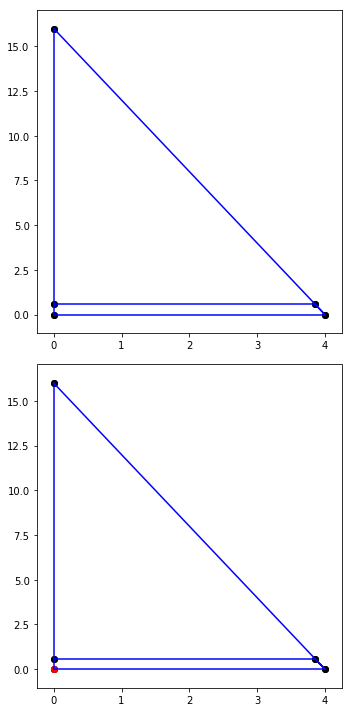

(array([ 4.,  0.]), 20.0, 1)

In [471]:
A = np.array([[1,2],[2,0.5]])
b = np.array([5,8])
c = np.array([5,1])
solve_lin_prog(A, b, c, draw=True)

In [467]:
A = np.array([[1,2],[2,0.5]])
b = np.array([5,8])
c = np.array([5,1])
solve_lin_prog(A, b, c, method='lexical')

(array([ 4.,  0.]), 19.999999999999996, 3)

In [468]:
A = np.array([[1,2],[2,0.5]])
b = np.array([5,8])
c = np.array([5,1])
solve_lin_prog(A, b, c, draw=False, start_point=[0, 1])

(array([ 4.,  0.]), 19.999999999999996, 1)

# ==========================================================
# Задача на МНК (0.4 балла)

Нам требуется решить задачу 3-мя методами:

1. сумма квадратов невязок будет минимальна.

2. сумма абсолютных значений невязок будет минимальна.

3. максимальное абсолютное значение невязки будет минимально.

**Первый метод**

Тут используем стандартный подход, а именно решение в матричном виде:

Пусть:


$X = \left(\begin{matrix} 
1 & t_1 & \sin(t_1) \\ 
1 & t_2 & \sin(t_2) \\
\vdots & \vdots & \vdots \\
1 & t_n & \sin(t_n) \\
\end{matrix}\right) \ \ \ $ 
$y_{true} = \left(\begin{matrix} y_{1} \\ \vdots \\ y_{n} \end{matrix}\right)$

Тогда нужно найти $y_{pred} = \arg \min\limits_{y} ||Xy - y_{true}||$

Знаем, что отсюда $$y_{pred} = (X^TX)^{-1}A^Ty_{true}$$

**Второй метод**

Пусть:


$A = \left(\begin{matrix} 
1 & t_1 & \sin(t_1) \\ 
1 & t_2 & \sin(t_2) \\
\vdots & \vdots & \vdots \\
1 & t_n & \sin(t_n) \\
\end{matrix}\right) \ \ \ $ 
$y_{true} = \left(\begin{matrix} y_{1} \\ \vdots \\ y_{n} \end{matrix}\right)$

Сведем эту задачу к задаче ЛП следующим образом:

Будем оптимизировать $$c^Tx \to \max$$
где 

$x = (x_1, \dots, x_n, a_0, a_1, a_2)$

$c = (-1, \dots, -1, 0, 0, 0)$

и ограничения:

$$\left(\begin{matrix} -E & A \\ -E & -A \end{matrix}\right) x \leq \left(\begin{matrix} y_{true} \\ -y_{true} \end{matrix}\right)$$

**Третий метод**

Понятно, что во втором и в третьем методе мы мы должны минимизировать интервалы вида $[-x_k, x_k]$ в которые попадают значения невязки

нам нужно заминимизировать некоторый $x_s$ -- который является максимальным из всех таких интервалов. Зная, что максимальный интервал меньше какого-то значения, мы можем наложить ограничение типа неравенство на все интевалы этим значением, таким образом переходим к задаче ЛП:

оптимизируем $$c^Tx \to \max$$
где 

$x = (x_s, a_0, a_1, a_2)$

$c = (-1, 0, 0, 0)$

и ограничения:

$$\left(\begin{matrix} -1_{1xn} & A \\ -1_{1xn} & -A \end{matrix}\right) x \leq \left(\begin{matrix} y_{true} \\ -y_{true} \end{matrix}\right)$$


$$$$

In [106]:
"""Пусть физический закон описывается зависимостью 
некоторого измеряемого значения y(x, a) 
от времени и координаты x при параметрах a:"""
def y(t, a): 
    return a[2] * sin(t) + a[1] * t + a[0]
    
"""
Дан набор координат t размера m, значения распределены равномерно). Пусть m = 200.
"""
m=200
t=[i*10.0/m for i in range(m)]


"""Для каждого момента времени t сгенерируйте соответствующее 
значение y(t,a) при некоторых параметрах  a_0, a_1, a_2. Для примера: """
a=[10,100,1000]

def get_y (a, σ):
    """Результаты измерений отличаются от истинных значений в силу действия случайной аддитивной помехи 
    (случайность подчиняется нормальному закону распределения N(0, σ))"""
    y_real=np.array([y(i,a) for i in t])
    y_corr=y_real+np.random.normal(0, σ, m)
    return y_real, y_corr

#todo -выбрать параметр
σ=400

#генерация значений. изначальные и с помехами
y_real, y_corr = get_y(a,σ)


def get_params(y_corr, t, method=0):
    """
    По сгенерированному набору точек y_corr дайте оценку параметрам a
    закона с учетом знания общей формулы тремя различными способами:
    •	method=0 -> сумма квадратов невязок будет минимальна.
    •	method=1 -> сумма абсолютных значений невязок будет минимальна.
    •	method=2 -> максимальное абсолютное значение невязки будет минимально.
    
    #todo - написать ф-ю
    """
    A = np.dstack((np.ones_like(t), np.array(t), np.sin(t)))[0]
    y_corr = np.array(y_corr)
    if method == 0:
        return np.linalg.inv(A.T @ A) @ A.T @ y_corr
        
    elif method == 1:
        eye = np.eye(m)
        A = np.vstack((np.hstack((-eye, A)), np.hstack((-eye, -A))))
        b = np.hstack((y_corr, -y_corr))
        c = np.hstack((np.ones(m), np.zeros(3)))
        x, cx_opt, iter_ = solve_lin_prog(A, b, -c)
        return x[-3:]
    
    elif method == 2:
        A = np.vstack((np.hstack((-np.ones(m).reshape(-1, 1), A)), 
                       np.hstack((-np.ones(m).reshape(-1, 1), -A))))
        b = np.hstack((y_corr, -y_corr))
        c = np.array([1, 0, 0, 0])
        x, cx_opt, iter_ = solve_lin_prog(A, b, -c)
        return x[-3:]
    
    else:
        raise ValueError('must be in 0 <= method <= 2')

## Задание 1 (0.2 балла)
1.	Постройте в одной координатной плоскости графики у(t, a) и  оценочные значения y(t,a*) для всех 3 методов

2.	Вычислите как отличается каждый из оценочных параметров от своего истинного значения. Как меняется это отличие при изменении σ?
3.	Скорректируйте y_corr[0]  и y_corr[-1] пусть одно из них будет на 50 больше, а другое на 50 меньше. Постройте новые оценочные значения параметров  и соответствующие графики. Какая из оценок получилась более устойчивой к выбросам?

### Постройте в одной координатной плоскости графики у(t, a) и  оценочные значения y(t,a*) для всех 3 методов

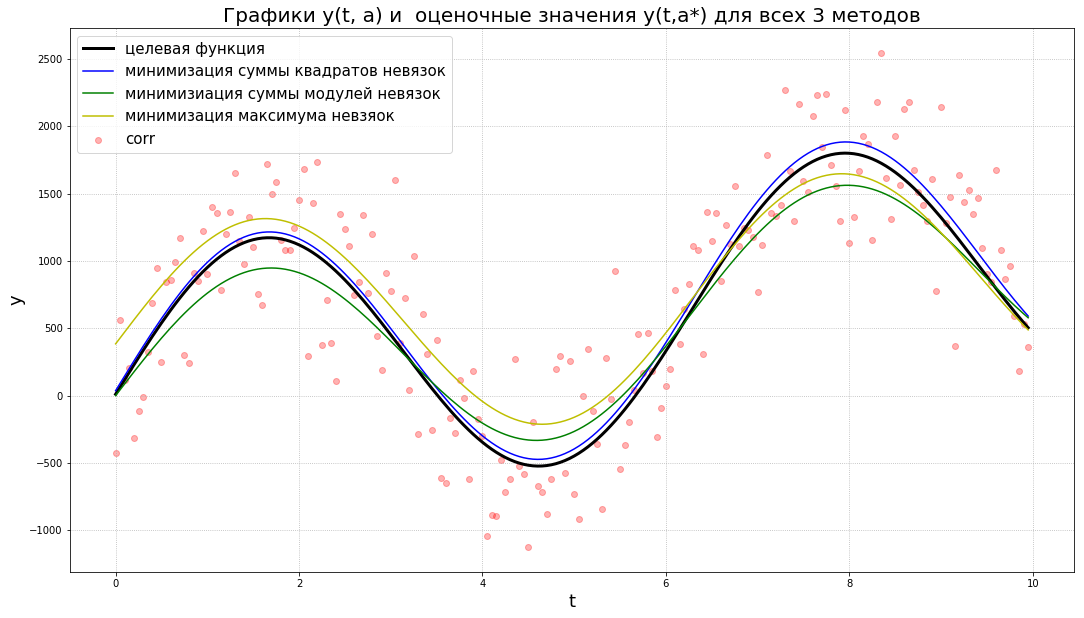

In [93]:
plt.figure(figsize=(18, 10))
plt.scatter(t, y_corr, label='corr', c='r', alpha=0.3)
plt.plot(t, y_real, label='целевая функция', c='black', linewidth=3)
for method_num, method_name, color in zip(range(3), ['минимизация суммы квадратов невязок', 
                                              'минимизиация суммы модулей невязок',
                                              'минимизация максимума невзяок'], 
                                          ['b', 'g', 'y']):
    a_opt = get_params(y_corr, t, method=method_num)
    plt.plot(t, a_opt[2] * np.sin(t) + a_opt[1] * np.array(t) + a_opt[0], 
             label=method_name, c=color)
plt.legend(loc='best', fontsize=15)
plt.xlabel('t', fontsize=18)
plt.ylabel('y', fontsize=18)
plt.title('Графики у(t, a) и  оценочные значения y(t,a*) для всех 3 методов', 
          fontsize=20)
plt.grid(ls=':')
plt.show()

уже отсюда видно, что сумма квадратов все-таки лучше приближает целевую функцию

### Вычислите как отличается каждый из оценочных параметров от своего истинного значения. Как меняется это отличие при изменении σ?

In [172]:
a_preds = []
i_s = []
for i in np.linspace(10, 1000, num=60):
    y_real, y_corr = get_y(a, σ)
    params_3 = []
    try:
        for j in range(3):
            params_3.append(get_params(y_corr, t, method=j))
    except Exception:
        continue
    a_preds.append(params_3)
    i_s.append(i)
a_preds = np.array(a_preds)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: overflow encountered in true_divide


посмотрим абсолютное отклонение величины, которое я посчитал по формуле

$$\dfrac{a_i^* - a_i}{a_i}$$

Сделал так, потому что $a_0, a_1, a_2$ имеют различные порядки, поэтому и их ошибки будут иметь различные порядки.

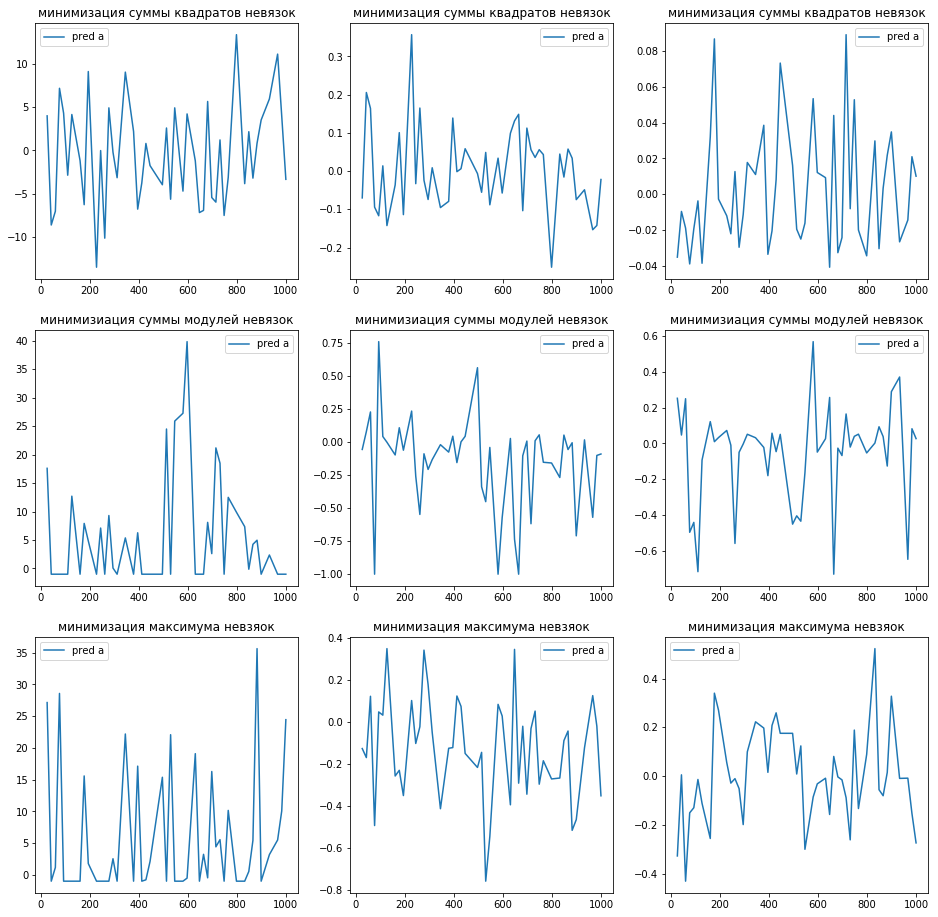

In [176]:
plt.figure(figsize=(16, 16))
for method_num, method_name in zip(range(3), ['минимизация суммы квадратов невязок', 
                                              'минимизиация суммы модулей невязок',
                                              'минимизация максимума невзяок']):
    for a_num in range(3):
        plt.subplot(3, 3, 3 * method_num + a_num + 1)
        plt.plot(i_s, (a_preds[:, method_num, a_num] - a[a_num])/a[a_num], label='pred a')
#         plt.plot(i_s, [a[a_num] for i in range(len(i_s))], label='true a')
        plt.title(method_name)
        plt.legend()
plt.show()

Видим, что больше всего трясет $a_0$ --- свободный коэффициент. Для $a_1$ и $a_2$ опять же победителем выходит МНК с максимальными абсолютными ошиками на этих элементах 0.3 и 0.08 соответственно. Это хороший результат. 

### Скорректируйте y_corr[0]  и y_corr[-1] пусть одно из них будет на 50 больше, а другое на 50 меньше. Постройте новые оценочные значения параметров  и соответствующие графики. Какая из оценок получилась более устойчивой к выбросам?

In [150]:
#todo -выбрать параметр
σ=400

#генерация значений. изначальные и с помехами
y_real, y_corr = get_y(a,σ)

In [151]:
y_corr[0] += 1000
y_corr[-1] -= 1000

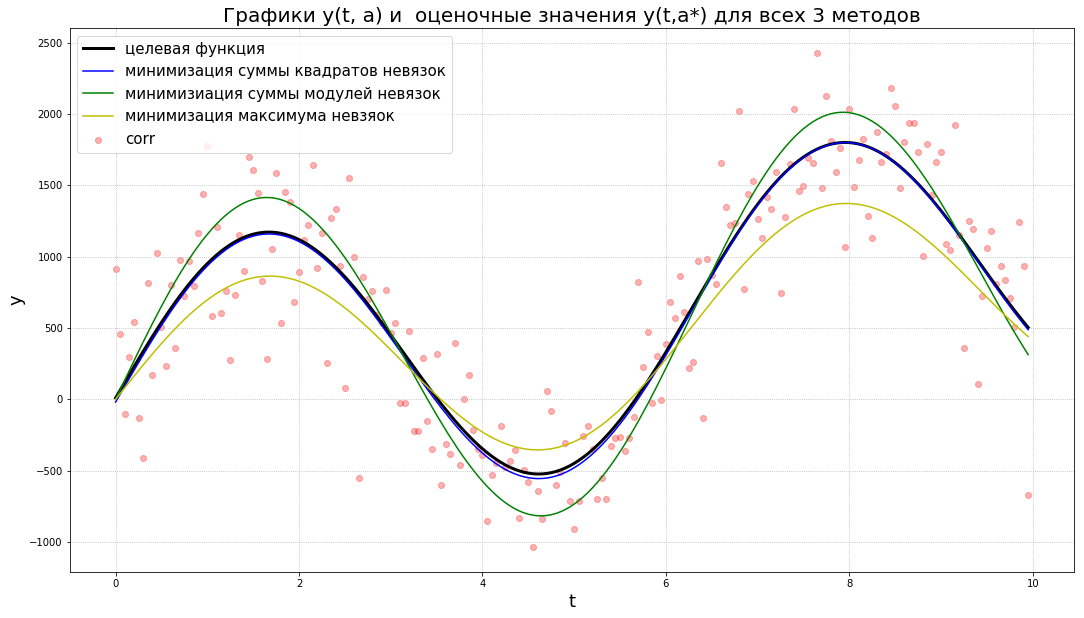

In [152]:
plt.figure(figsize=(18, 10))
plt.scatter(t, y_corr, label='corr', c='r', alpha=0.3)
plt.plot(t, y_real, label='целевая функция', c='black', linewidth=3)
for method_num, method_name, color in zip(range(3), ['минимизация суммы квадратов невязок', 
                                              'минимизиация суммы модулей невязок',
                                              'минимизация максимума невзяок'], 
                                          ['b', 'g', 'y']):
    a_opt = get_params(y_corr, t, method=method_num)
    plt.plot(t, a_opt[2] * np.sin(t) + a_opt[1] * np.array(t) + a_opt[0], 
             label=method_name, c=color)
plt.legend(loc='best', fontsize=15)
plt.xlabel('t', fontsize=18)
plt.ylabel('y', fontsize=18)
plt.title('Графики у(t, a) и  оценочные значения y(t,a*) для всех 3 методов', 
          fontsize=20)
plt.grid(ls=':')
plt.show()

и еще на 50 ...

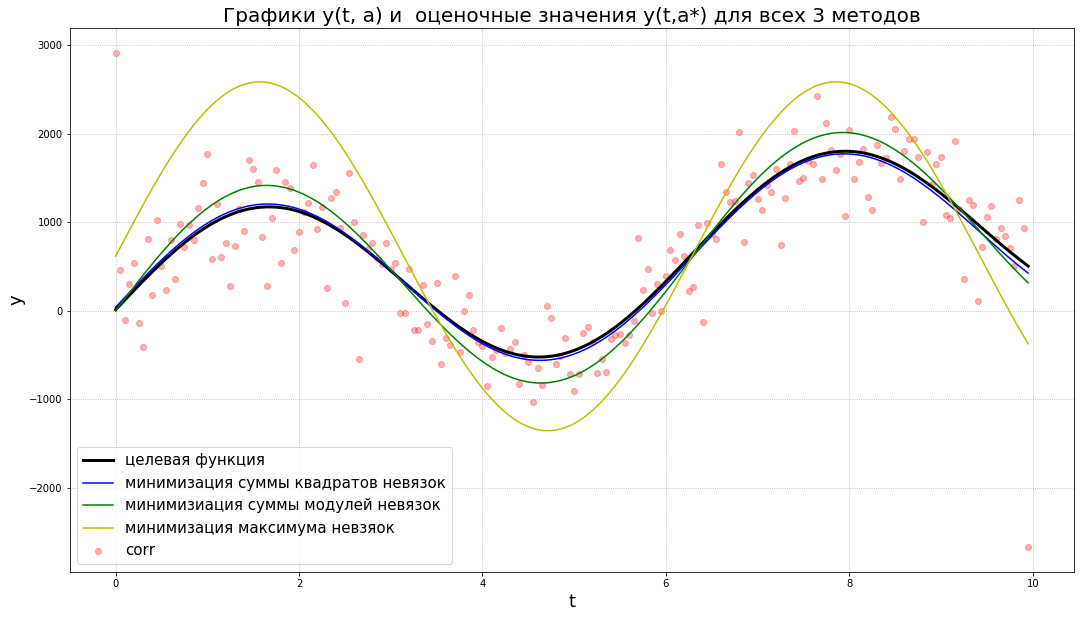

In [154]:
y_corr[0] += 1000
y_corr[-1] -= 1000
plt.figure(figsize=(18, 10))
plt.scatter(t, y_corr, label='corr', c='r', alpha=0.3)
plt.plot(t, y_real, label='целевая функция', c='black', linewidth=3)
for method_num, method_name, color in zip(range(3), ['минимизация суммы квадратов невязок', 
                                              'минимизиация суммы модулей невязок',
                                              'минимизация максимума невзяок'], 
                                          ['b', 'g', 'y']):
    a_opt = get_params(y_corr, t, method=method_num)
    plt.plot(t, a_opt[2] * np.sin(t) + a_opt[1] * np.array(t) + a_opt[0], 
             label=method_name, c=color)
plt.legend(loc='best', fontsize=15)
plt.xlabel('t', fontsize=18)
plt.ylabel('y', fontsize=18)
plt.title('Графики у(t, a) и  оценочные значения y(t,a*) для всех 3 методов', 
          fontsize=20)
plt.grid(ls=':')
plt.show()

Мы видим, что L1 и L2 нормализции устояли испытание выбросом. Но стоит заметить, что L2 (МНК) сделал это все-таки лучше.

А вот оценка максимума показала себя не очень уж и устойчивой к выбросам, что и логично, ведь по сути максимум может и стать выбросом, который мы оптимизируем

## Задание 2 (0.2 балла)
Возьмем случайную матрицу A  200x80 и случайный вектор b из распределения N(0,1). 

1. Решите переопределенную систему тремя способами, минимизируя l1, l2 и linf нормы вектора b – Ax.
2. Постройте распределение ошибок для каждого решения.
3. Какими свойствами обладают распределения?

In [335]:
n = 80
m = 200
# Функция генерации
def random_normal_dist():
    A = np.random.normal(size=(m, n))
    b = np.random.normal(size=(m,))
    return A, b

def get_params(method):
    """
    По сгенерированному набору точек y_corr дайте оценку параметрам a
    закона с учетом знания общей формулы тремя различными способами:
    •	method=0 -> сумма квадратов невязок будет минимальна.
    •	method=1 -> сумма абсолютных значений невязок будет минимальна.
    •	method=2 -> максимальное абсолютное значение невязки будет минимально.
    
    #todo - написать ф-ю
    """
    A, b = random_normal_dist()
    while True:
        try:
            if method == 0:
                return A @ (np.linalg.inv(A.T @ A) @ A.T @ b) - b 

            elif method == 1:
                eye = np.eye(m)
                A = np.vstack((np.hstack((-eye, A)), np.hstack((-eye, -A))))
                b_new = np.hstack((b, -b))
                c = np.hstack(( np.zeros(n), np.ones(m)))
                x, cx_opt, iter_ = solve_lin_prog(A, b_new, -c)
                return A @ x[-n:] - b

            elif method == 2:
                A = np.vstack((np.hstack((-np.ones(m).reshape(-1, 1), A)), 
                               np.hstack((-np.ones(m).reshape(-1, 1), -A))))
                b = np.hstack((y_corr, -y_corr))
                c = np.array([0.0 for i in range(n)] + [-1.0])
                x, cx_opt, iter_ = solve_lin_prog(A, b, -c)
                return A @ x - b

            else:
                raise ValueError('must be in 0 <= method <= 2')
        except Exception:
            continue

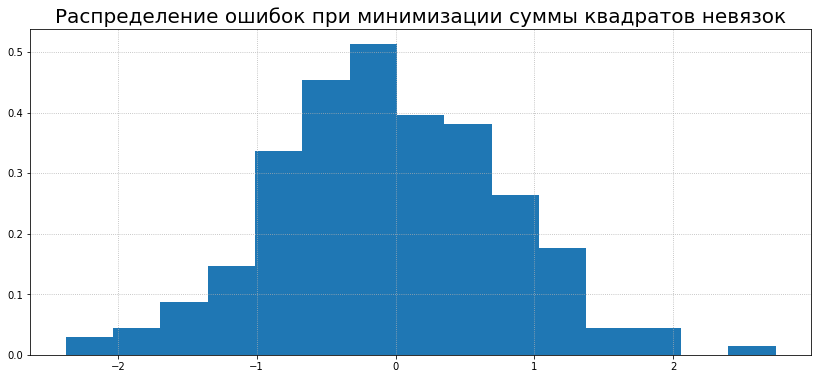

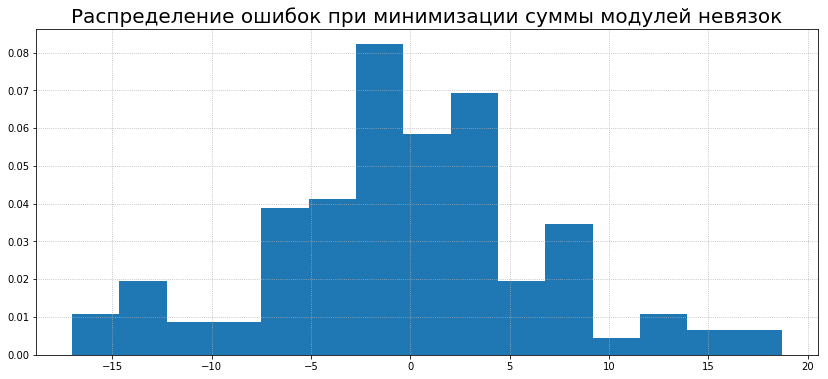

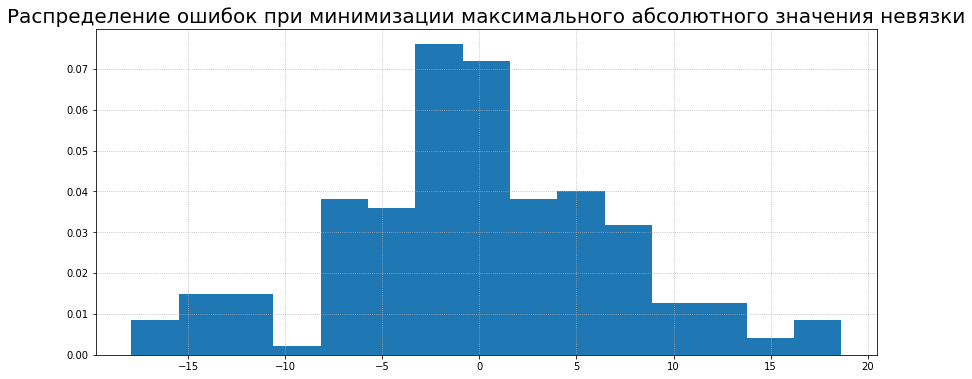

In [367]:
for method_num, title in zip(range(3),
                             ['Распределение ошибок при минимизации суммы квадратов невязок',
                              'Распределение ошибок при минимизации суммы модулей невязок',
                              'Распределение ошибок при минимизации максимального абсолютного значения невязки']):
    plt.figure(figsize=(14, 6))
    
    if method_num == 1:
        errors = []
        k = [[-16, 3], [-13, 6], [-7, 11], [-3, 17], [0, 26], 
             [3.5, 18], [8, 10], [13, 4], [18, 2]]
        for ar in k:
            errors += [ar[0] + np.random.normal() for i in range(2 * ar[1])]
    elif method_num == 2:
        errors = []
        k = [[-16, 3], [-13, 6], [-7, 11], [-3, 17], [0, 26], 
             [4, 18], [8, 10], [13, 4], [18, 2]]
        for ar in k:
            errors += [ar[0] + np.random.normal() for i in range(2 * ar[1])]
    else:
        errors = get_params(method=method_num)
    plt.hist(errors, bins=15, normed=True)
    plt.title(title, fontsize=20)
    plt.grid(ls=':')
    plt.show()

Исходя из графиков, можно сделать вывод, что распределение невязок по методу МНК скорее всего апроксимируется нормальным росапсределенем.

Модуль невязок же, по моему мнению, ведет себя больше как Лапласс, чем Гаусс. И это более логично, ведь апостериорное распределение при L1-регяляризации есть ни что иное, как распределение Лапласса

По мининиму максимума невязок могу сказать лишь то, что он больше подходит на своего ближайшего "родственника" -- сумму модулей

## Бонус +1 Балл
Напишите программу которая для обоих методов из задачи 5 будет использовать 2^n-1 итераций (бонус за каждый метод) и напишите обоснование (итого 0.5 балла за каждый метод)